In [16]:
%run examples/key_imports.py
%run examples/bs.py
%run examples/nn_archi.py
%run examples/utils.py

X_df = pd.read_csv("bs.csv")
feat_names = ['log(S/K)', 'ttm']
f_to_i = lambda x: feat_names.index(x)
Xs = X_df[feat_names].values
ys = X_df['digital_true']

print("BASELINE MSE: ", np.mean((ys - ys.mean()) ** 2))
print("BASELINE MAE: ", np.mean(np.abs(ys - ys.mean())))

all_res = []

BASELINE MSE:  0.13237814283225016
BASELINE MAE:  0.30221306309031204


In [17]:
HIDDEN_UNITS = 100
LAYERS = 2
dropout_ratio = 0.0
HIDDEN_ACT = 'softplus'
N_FEATS = 2
OUTPUT_ACT = 'sigmoid'
DROPOUT_RATIO = 0.0
LR = 1e-3
BATCH_SIZE = 32
EPOCHS = 10
BATCH_NORM = False

loss_fn = tf.keras.losses.MeanSquaredError()

METRICS = [tf.keras.metrics.MeanAbsoluteError(), tf.keras.metrics.RootMeanSquaredError()]
VAL_SPLIT = 0.2
CALLBACKS = [EarlyStopping(patience=5)]


opt = Adam(learning_rate = LR)
ffn = make_model(N_FEATS, 
                 HIDDEN_UNITS, 
                 LAYERS, 
                 DROPOUT_RATIO, 
                 HIDDEN_ACT, 
                 OUTPUT_ACT, 
                 BATCH_NORM)


ffn.compile(optimizer=opt, loss=loss_fn, metrics = METRICS)
history = ffn.fit(Xs, ys, 
                  epochs = EPOCHS, 
                  batch_size=BATCH_SIZE, 
                  validation_split = VAL_SPLIT,
                  shuffle=True,
                  callbacks=CALLBACKS)

Epoch 1/10
1639/1639 [==============================] - 3s 2ms/step - loss: 0.0119 - mean_absolute_error: 0.0537 - root_mean_squared_error: 0.1093 - val_loss: 0.0053 - val_mean_absolute_error: 0.0366 - val_root_mean_squared_error: 0.0727
Epoch 2/10
1639/1639 [==============================] - 3s 2ms/step - loss: 0.0053 - mean_absolute_error: 0.0358 - root_mean_squared_error: 0.0728 - val_loss: 0.0043 - val_mean_absolute_error: 0.0323 - val_root_mean_squared_error: 0.0656
Epoch 3/10
1639/1639 [==============================] - 3s 2ms/step - loss: 0.0049 - mean_absolute_error: 0.0341 - root_mean_squared_error: 0.0697 - val_loss: 0.0044 - val_mean_absolute_error: 0.0334 - val_root_mean_squared_error: 0.0662
Epoch 4/10
1639/1639 [==============================] - 3s 2ms/step - loss: 0.0031 - mean_absolute_error: 0.0264 - root_mean_squared_error: 0.0558 - val_loss: 0.0016 - val_mean_absolute_error: 0.0186 - val_root_mean_squared_error: 0.0401
Epoch 5/10
1639/1639 [==========================

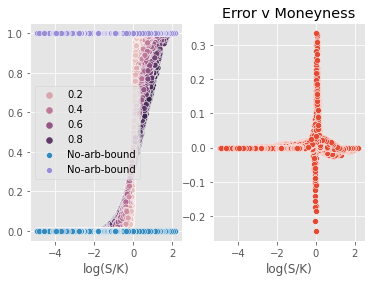

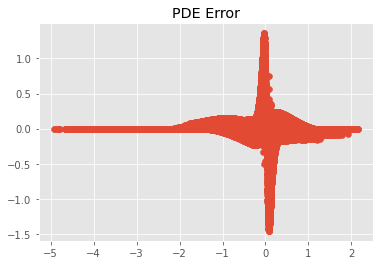

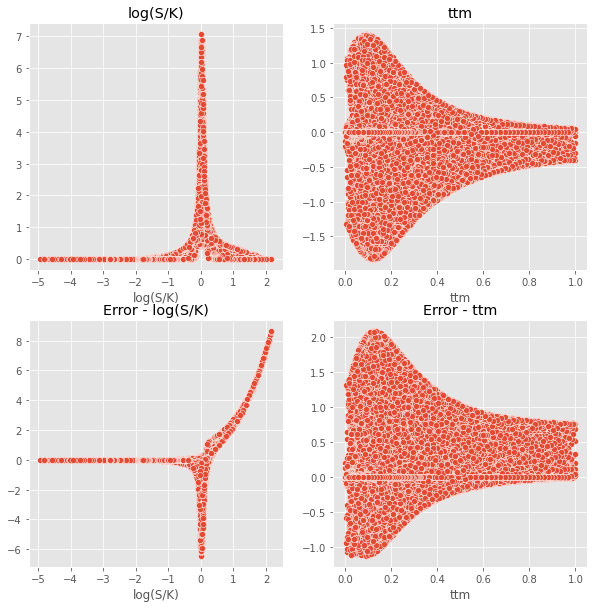

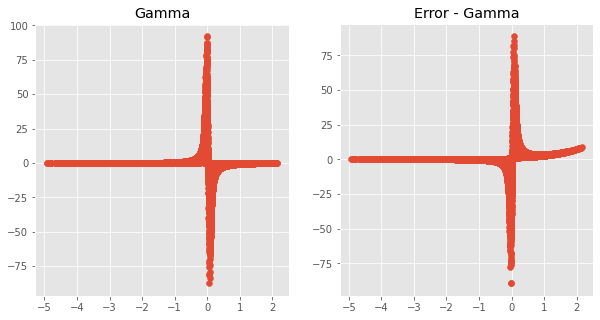

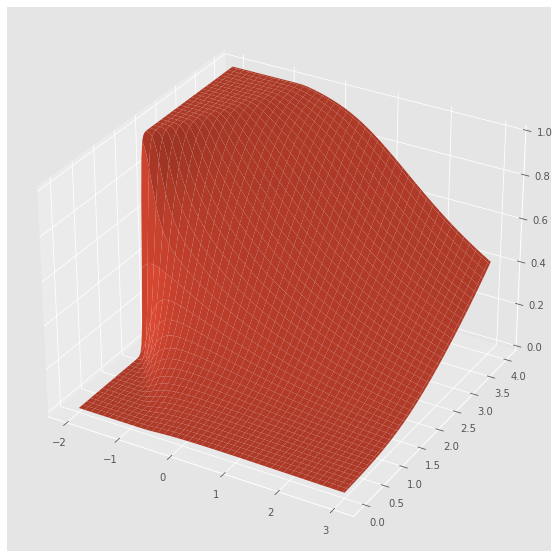

In [18]:
"""
Prediction Errors
"""
model = ffn
moneyness = np.exp(Xs[:, f_to_i("log(S/K)")])
ttm = np.exp(Xs[:, f_to_i("ttm")])
true = X_df['call_true']
preds = model.predict(Xs)
try:
    preds = preds.reshape(-1)
except:
    pass

"""
Compute all Gradients, Hessian
"""

X_tensor = tf.Variable(Xs)
with tf.GradientTape() as tape2:
    with tf.GradientTape() as tape:
        output = model(X_tensor)
        grads = tape.gradient(output, X_tensor)
    hessian1 = tape2.gradient(grads[:, f_to_i("log(S/K)")], X_tensor)

grads = grads.numpy()
hessian_moneyness = hessian1.numpy()[:, [0]]
    
all_res += [bs_eval_wrapper(X_df, 
                    true_val = X_df['digital_true'].values, 
                    preds = preds,
                    grads = grads,
                    hessian_moneyness = hessian_moneyness,
                    lower_bound = 0.0, 
                    upper_bound = 1.0,
                    METHOD = "standard_ffn"
                    )]

"""
Visualise call surface
"""
SK = np.linspace(-2, 3, 128) 
ts = np.linspace(0, 4, 128)
X = np.array(list(product(SK, ts)))
visualise_surface(SK, ts, model(X).numpy())

<AxesSubplot:>

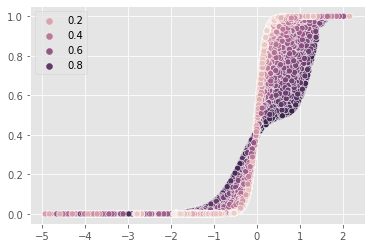

In [19]:
from sklearn.preprocessing import PolynomialFeatures
from sklearn.linear_model import LinearRegression, LogisticRegression
X2 = PolynomialFeatures(degree=5).fit_transform(Xs)

logit_reg = LogisticRegression(fit_intercept=False).fit(X2, X_df['digital_payoff'])

sns.scatterplot(x = Xs[:, f_to_i("log(S/K)")], 
                y = logit_reg.predict_proba(X2)[:,1], 
                hue = Xs[:, f_to_i("ttm")])

In [20]:
preds = logit_reg.predict_proba(X2)[:,1]

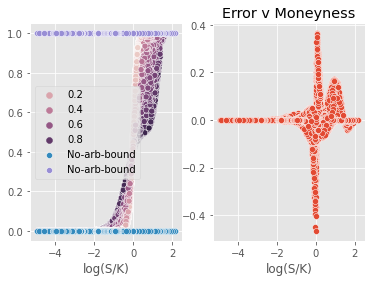

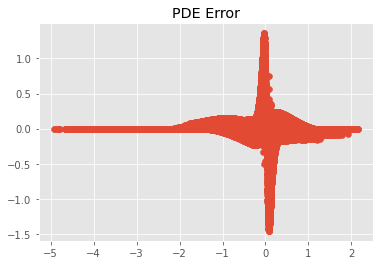

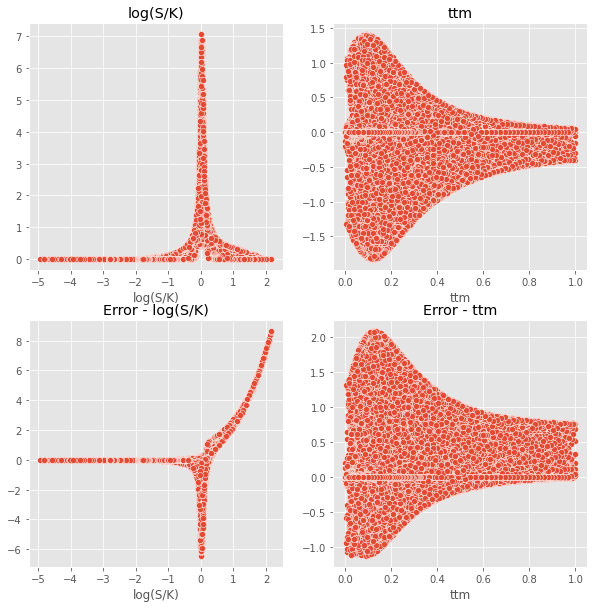

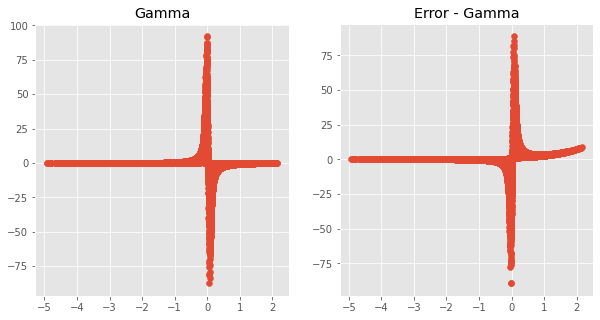

In [21]:
all_res += [bs_eval_wrapper(X_df, 
                    true_val = X_df['digital_true'].values, 
                    preds = preds,
                    grads = grads,
                    hessian_moneyness = hessian_moneyness,
                    lower_bound = 0.0, 
                    upper_bound = 1.0,
                    METHOD = "logit"
                    )]


In [22]:
pd.concat(all_res).T.style.background_gradient()

,standard_ffn,logit
pred_l1,0.005963,0.014602
pred_l2,0.015614,0.035482
pred_l_inf,0.334855,0.466000
pred_lower_bound_violation,0.000000,0.000000
PDE_mean,0.000294,0.000294
PDE_l1,0.045046,0.045046
PDE_l2,0.130551,0.130551
PDE_l_inf,1.456321,1.456321
monotonicity_error,0.000000,0.000000
time_value_error,0.237106,0.237106
